# **Sentimen Analisis Review Game di Play Store - Evil Nun**

## **Import Library**

In [231]:
from google_play_scraper import app, reviews, Sort, reviews_all
import pandas as pd
from scipy.stats import alpha
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from collections import Counter

from imblearn.over_sampling import SMOTE

pd.options.mode.chained_assignment = None
import numpy as np

seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import datetime as dt
import re
import string
import csv
import requests
from gensim.models import Word2Vec
from io import StringIO
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/refanzzzz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/refanzzzz/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/refanzzzz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Scraping Dataset**

In [2]:
# Mengambil semua ulasan dari game dengan ID 'com.keplerians.evilnun' di Google Play Store
# Proses scraping meungkin memerlukan waktu beberapa saat tergantung pada jumlah ulasan yang ada
scraper_view = reviews_all(
    'com.keplerians.evilnun',  # ID aplikasi
    lang='id',  # Bahasa ulasan (default: 'en')
    country='id',  # Negara (default: 'en')
    sort=Sort.MOST_RELEVANT,  # Urutan ulasan (default: Sort.MOST_RELEVANT)
    count=12000  # Jumlah maksimum ulasan yang ingin diambil
)

## **Loading Dataset**

In [3]:
# Membuat DataFrame hasil dari scraping
# Melakukan slicing sebanyak 10000 data, karena reviews_all mengabaikan parameter count dan mengambil seluruh ulasan
game_reviews_df = pd.DataFrame(scraper_view[:12000])

# Mengkonversi DataFrame menjadi berkas CSV
game_reviews_df.to_csv('evil_nun_reviews.csv', index=False)

In [4]:
# Membuat DataFrame dari hasil scrape_view
game_reviews_df = pd.DataFrame(scraper_view[:12000])

# Menghitung jumlah baris dan kolom pada DataFrame
reviews_count, columns_count = game_reviews_df.shape

print("Jumlah ulasan: ", reviews_count)
print("Jumlah kolom: ", columns_count)

Jumlah ulasan:  12000
Jumlah kolom:  11


In [5]:
# Menampilkan lima baris pertama dari DataFrame game_reviews_df
game_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,55ed02a9-0ed3-4012-9cff-3ccd6a558172,Alif Fathan,https://play-lh.googleusercontent.com/a/ACg8oc...,Terima kasih untuk Keplerians/Developer yg tel...,5,11,1.9.1,2025-04-09 15:56:37,None,NaT,1.9.1
1,4e4b81f5-7e49-4c20-8b59-7e8d05546b92,Maura Qory Muzdalifa,https://play-lh.googleusercontent.com/a-/ALV-U...,"jujur game ini seru bgt😖🙏, tapi masalah nya in...",5,44,1.9.1,2025-03-23 13:52:19,None,NaT,1.9.1
2,cb2d5f74-8a08-4c84-8bd0-172e9ad2d721,eko setiawan,https://play-lh.googleusercontent.com/a/ACg8oc...,Dari 2019 sampai 2025 (1.8.9) game ini udah ba...,2,37,1.9.0,2025-01-31 17:01:13,Hi! This issue has been just fixed 🔧 You can u...,2025-03-25 18:30:55,1.9.0
3,e331edd9-69d5-41b3-bdfc-3781dfd139b5,Jhosu Tumanggor,https://play-lh.googleusercontent.com/a-/ALV-U...,"ngebug nya banyak,pas topeng nya sudah terkump...",3,1,1.9.1,2025-03-18 21:22:20,None,NaT,1.9.1
4,df9b4228-d28a-4df5-a02c-9316a7c32195,Keisya Kamilla,https://play-lh.googleusercontent.com/a/ACg8oc...,Terima kasih kepada developer Keplerians karen...,5,14,1.9.1,2025-03-21 20:29:49,Hi! This issue has been just fixed 🔧 You can u...,2025-03-18 20:49:27,1.9.1


## **Cleaning Dataset**

In [6]:
# Menampilkan informasi tentang DataFrame game_reviews_df
game_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              12000 non-null  object        
 1   userName              12000 non-null  object        
 2   userImage             12000 non-null  object        
 3   content               12000 non-null  object        
 4   score                 12000 non-null  int64         
 5   thumbsUpCount         12000 non-null  int64         
 6   reviewCreatedVersion  4300 non-null   object        
 7   at                    12000 non-null  datetime64[ns]
 8   replyContent          253 non-null    object        
 9   repliedAt             253 non-null    datetime64[ns]
 10  appVersion            4300 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 1.0+ MB


In [7]:
# Melakukan drop beberapa kolom dari DataFrame game_reviews_df
clean_df = game_reviews_df.drop(columns=['reviewCreatedVersion', 'repliedAt', 'replyContent', 'appVersion'])

# Menampilkan informasi tentang DataFrame clean_df
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   reviewId       12000 non-null  object        
 1   userName       12000 non-null  object        
 2   userImage      12000 non-null  object        
 3   content        12000 non-null  object        
 4   score          12000 non-null  int64         
 5   thumbsUpCount  12000 non-null  int64         
 6   at             12000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 656.4+ KB


In [8]:
# Mengecek apakah ada data yang duplikat
duplicate_count = clean_df.duplicated().sum()
print("Jumlah duplikasi: ", duplicate_count)

Jumlah duplikasi:  0


## **Preprocessing Text**

In [108]:
# Membuat helper function untuk menghapus tanda baca
def remove_punctuation(text):
    # Membuat set yang berisi semua tanda baca
    punctuation_set = set(string.punctuation)

    # Menghapus tanda baca dari teks
    text_without_punctuation = ''

    for char in text:
        if char not in punctuation_set:
            text_without_punctuation += char
        else:
            text_without_punctuation += ' '

    return ' '.join(text_without_punctuation.split())

In [138]:
# Membuat helper function untuk membersihkan teks
def cleaning_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Menghapus hashtag
    text = re.sub(r'RT[\s]+', '', text)  # Menghapus retweet
    text = re.sub(r'http\S+', '', text)  # Menghapus link
    text = re.sub(r'[0-9]+', '', text)  # Menghapus angka
    text = remove_punctuation(text)  # Menghapus tanda baca
    text = re.sub(r'[^\w\s]', '', text)  # Menghapus karakter selain huruf dan angka
    text = text.replace('\n', ' ')  # Mengganti baris baru dengan spasi
    text = text.strip(' ')  # Menghapus karakter awal dan akhir

    return text

In [111]:
# Membuat helper function untuk mengubah teks menjadi huruf kecil
def casefolding_text(text):
    text = text.lower()
    return text

In [112]:
# Memecah atau membagi string, teks menjadi daftar token
def tokenizing_text(text):
    text = word_tokenize(text)
    return text

In [157]:
# Menghapus stopwords dalam teks
def filtering_text(text):
    list_stopwords = set(stopwords.words('indonesian'))
    list_stopwords1 = set(stopwords.words('english'))

    factory = StopWordRemoverFactory()
    stopwords_sastrawi = factory.get_stop_words()

    game_stopwords = ['game', 'update', 'versi', 'download', "evil nun", "misi", "chapter", "youtube", "youtuber", "yt",
                      "developer", "dvloper", "install", "aci", "miawaug", "miaw", "aug", "evil", "nun", "nan",
                      "playstore", "play", "store", "topeng", "horor", "granny", "admin", "save", "load", "miauaug",
                      "keplerians", "apk", "aplikasi", "balon", "udara", "pintu", "buku", "mask", "cable"]

    general_stopwords = ['iya', 'yaa', 'yaaa' 'gak', 'nya', 'na', 'sih', 'ku', "di", "ga", "ya", "gaa", "loh", "kah",
                         "woi",
                         "woii", "woy",
                         "anjir", "njir", "deh", "ah", "coy", "wkwkwk", "wkwkwkwk", "cuy", "dehh", "deh", "dh", "donk",
                         "eh", "hahaha", "hehehe", "ih", "lho", "mah", "nge", "ny", "nyaa", "omg", "yah", "yey", "tuh",
                         "apa", "allah", "asalamualaikum", "bye", "wr wb", "wr", "wb", "asalamu", "alaikum", "assalamu"]

    list_stopwords.update(game_stopwords)
    list_stopwords.update(stopwords_sastrawi)
    list_stopwords.update(list_stopwords1)
    list_stopwords.update(general_stopwords)

    filtered = []

    for txt in text:
        if txt not in list_stopwords:
            filtered.append(txt)

    text = filtered

    return text


In [114]:
# Membuat helper function untuk mengubah kata menjadi kata dasar
def stemming_text(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]

    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

In [115]:
# Mengkonversi list kata menjadi kalimat
def to_sentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [116]:
# Mengirim request HTTP untuk mendapatkan berkas CSV dari Github
slangwords_response = requests.get(
    "https://raw.githubusercontent.com/refanz/indonesian-slangwords/master/data/indonesian-slangwords.csv")


# Membuat funngsi untuk membaca hasil response dari Github
def read_data(response):
    dictionary = dict()

    if response.status_code == 200:
        reader = csv.reader(StringIO(response.text), delimiter=',')

        for row in reader:
            dictionary[row[0]] = int(row[1]) if re.match(r'^-?\d+$', str(row[1])) else row[1]

        return dictionary
    else:
        print("Failed to fetch data from Github")
        return None


slangwords = read_data(slangwords_response)
slangwords

{'@': 'di',
 'abis': 'habis',
 'wtb': 'beli',
 'masi': 'masih',
 'wts': 'jual',
 'wtt': 'tukar',
 'bgt': 'banget',
 'maks': 'maksimal',
 'plisss': 'tolong',
 'bgttt': 'banget',
 'indo': 'indonesia',
 'bgtt': 'banget',
 'ad': 'ada',
 'rv': 'redvelvet',
 'plis': 'tolong',
 'pls': 'tolong',
 'cr': 'sumber',
 'cod': 'bayar ditempat',
 'adlh': 'adalah',
 'afaik': 'as far as i know',
 'ahaha': 'haha',
 'aj': 'saja',
 'ajep-ajep': 'dunia gemerlap',
 'ak': 'saya',
 'akika': 'aku',
 'akkoh': 'aku',
 'akuwh': 'aku',
 'alay': 'norak',
 'alow': 'halo',
 'ambilin': 'ambilkan',
 'ancur': 'hancur',
 'anjrit': 'anjing',
 'anter': 'antar',
 'ap2': 'apa-apa',
 'apasih': 'apa sih',
 'apes': 'sial',
 'aps': 'apa',
 'aq': 'saya',
 'aquwh': 'aku',
 'asbun': 'asal bunyi',
 'aseekk': 'asyik',
 'asekk': 'asyik',
 'asem': 'asam',
 'aspal': 'asli tetapi palsu',
 'astul': 'asal tulis',
 'ato': 'atau',
 'au ah': 'tidak mau tahu',
 'awak': 'saya',
 'ay': 'sayang',
 'ayank': 'sayang',
 'b4': 'sebelum',
 'bakalan': '

In [117]:
# Mengubah kata slang menjadi formal
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [158]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaning_text)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di dalam kolom 'text_casefolding'
clean_df['text_casefolding'] = clean_df['text_clean'].apply(casefolding_text)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefolding'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di kolom 'text_tokenizing'
clean_df['text_tokenizing'] = clean_df['text_slangwords'].apply(tokenizing_text)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopwords'] = clean_df['text_tokenizing'].apply(filtering_text)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di kolom 'text_to_sentence'
clean_df['text_final'] = clean_df['text_stopwords'].apply(to_sentence)

In [159]:
# Menampilkan DataFrame clean_df setelah dilakukan pemrosesan teks
clean_df

,reviewId,userName,userImage,content,score,thumbsUpCount,at,text_clean,text_casefolding,text_slangwords,text_tokenizing,text_stopwords,text_final
0,55ed02a9-0ed3-4012-9cff-3ccd6a558172,Alif Fathan,https://play-lh.googleusercontent.com/a/ACg8ocJgBGmpWfsrCYDShqooDNNoubS1oPG5dXkTFExwVYD4e9ZFDw=mo,"Terima kasih untuk Keplerians/Developer yg telah membuat evil nun, sangat bagus dan menegangkan dah juga seru, aku berharap ada Evil nun the broken maks di play store dan tolong ya ketika sudah tamat lalu aku hapus cukup lama lalu instal kembali tolong proses ny/ topeng nya belum jadi gitu maksudku dari awal mencari oil grailnya dan update lagi jalan keluar yang baru, kalau bisa hehe. sudah gitu aja⭐⭐⭐⭐⭐",5,11,2025-04-09 15:56:37,Terima kasih untuk Keplerians Developer yg telah membuat evil nun sangat bagus dan menegangkan dah juga seru aku berharap ada Evil nun the broken maks di play store dan tolong ya ketika sudah tamat lalu aku hapus cukup lama lalu instal kembali tolong proses ny topeng nya belum jadi gitu maksudku dari awal mencari oil grailnya dan update lagi jalan keluar yang baru kalau bisa hehe sudah gitu aja,terima kasih untuk keplerians developer yg telah membuat evil nun sangat bagus dan menegangkan dah juga seru aku berharap ada evil nun the broken maks di play store dan tolong ya ketika sudah tamat lalu aku hapus cukup lama lalu instal kembali tolong proses ny topeng nya belum jadi gitu maksudku dari awal mencari oil grailnya dan update lagi jalan keluar yang baru kalau bisa hehe sudah gitu aja,terima kasih untuk keplerians developer yang telah membuat evil nun sangat bagus dan menegangkan deh juga seru aku berharap ada evil nun the broken maksimal di play store dan tolong iya ketika sudah tamat lalu aku hapus cukup lama lalu install kembali tolong proses ny topeng nya belum jadi gitu maksudku dari awal mencari oil grailnya dan update lagi jalan keluar yang baru kalau bisa he sudah gitu saja,"[terima, kasih, untuk, keplerians, developer, yang, telah, membuat, evil, nun, sangat, bagus, dan, menegangkan, deh, juga, seru, aku, berharap, ada, evil, nun, the, broken, maksimal, di, play, store, dan, tolong, iya, ketika, sudah, tamat, lalu, aku, hapus, cukup, lama, lalu, install, kembali, tolong, proses, ny, topeng, nya, belum, jadi, gitu, maksudku, dari, awal, mencari, oil, grailnya, dan, update, lagi, jalan, keluar, yang, baru, kalau, bisa, he, sudah, gitu, saja]","[terima, kasih, bagus, menegangkan, seru, berharap, broken, maksimal, tamat, hapus, proses, gitu, maksudku, mencari, oil, grailnya, jalan, gitu]",terima kasih bagus menegangkan seru berharap broken maksimal tamat hapus proses gitu maksudku mencari oil grailnya jalan gitu
1,4e4b81f5-7e49-4c20-8b59-7e8d05546b92,Maura Qory Muzdalifa,https://play-lh.googleusercontent.com/a-/ALV-UjUrdqTkCAf0AAmCOTRxQnSIGs4dpuv0bqqFbCUiewO4v0N0H5g,"jujur game ini seru bgt😖🙏, tapi masalah nya ini kok pas saya lagi offline loadingnya malah nyangkut udah di tunggu sampe satu 1 jam masih aja nyangkut tapi pas saya online baru loadingnya lancar ini kenapa? tolong di perbaiki ya soalnya ini sangat-sangat menganggu bagi saya yang jarang sekali bisa online🙏",5,44,2025-03-23 13:52:19,jujur game ini seru bgt tapi masalah nya ini kok pas saya lagi offline loadingnya malah nyangkut udah di tunggu sampe satu jam masih aja nyangkut tapi pas saya online baru loadingnya lancar ini kenapa tolong di perbaiki ya soalnya ini sangat sangat menganggu bagi saya yang jarang sekali bisa online,jujur game ini seru bgt tapi masalah nya ini kok pas saya lagi offline loadingnya malah nyangkut udah di tunggu sampe satu jam masih aja nyangkut tapi pas saya online baru loadingnya lancar ini kenapa tolong di perbaiki ya soalnya ini sangat sangat menganggu bagi saya yang jarang sekali bisa online,jujur game ini seru banget tapi masalah nya ini kok ketika saya lagi offline loadingnya bahkan nyangkut sudah di tunggu sampai satu jam masih saja nyangkut tapi ketika saya online baru loadingnya lancar ini kenapa tolong di perb

In [160]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   reviewId          12000 non-null  object        
 1   userName          12000 non-null  object        
 2   userImage         12000 non-null  object        
 3   content           12000 non-null  object        
 4   score             12000 non-null  int64         
 5   thumbsUpCount     12000 non-null  int64         
 6   at                12000 non-null  datetime64[ns]
 7   text_clean        12000 non-null  object        
 8   text_casefolding  12000 non-null  object        
 9   text_slangwords   12000 non-null  object        
 10  text_tokenizing   12000 non-null  object        
 11  text_stopwords    12000 non-null  object        
 12  text_final        12000 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(10)
memory usage: 1.2+ MB


## **Labeling**

In [161]:
# Mengirim request HTTP untuk mendapatkan berkas CSV dari Github
http_response_1 = requests.get("https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv")

# Mengirim request HTTP untuk mendapatkan berkas CSV dari Github
http_response_2 = requests.get("https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv")

lexicon_positive = read_data(http_response_1)
lexicon_negative = read_data(http_response_2)

In [162]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        if word in lexicon_positive:
            score = score + lexicon_positive[word]

    for word in text:
        if word in lexicon_negative:
            score = score + lexicon_negative[word]

    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [163]:
results = clean_df['text_stopwords'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
labeled_df = clean_df.copy()
labeled_df['polarity_score'] = results[0]
labeled_df["polarity"] = results[1]
print(labeled_df['polarity'].value_counts())

polarity
negative    6617
positive    3801
neutral     1582
Name: count, dtype: int64


In [164]:
labeled_df

,reviewId,userName,userImage,content,score,thumbsUpCount,at,text_clean,text_casefolding,text_slangwords,text_tokenizing,text_stopwords,text_final,polarity_score,polarity
0,55ed02a9-0ed3-4012-9cff-3ccd6a558172,Alif Fathan,https://play-lh.googleusercontent.com/a/ACg8ocJgBGmpWfsrCYDShqooDNNoubS1oPG5dXkTFExwVYD4e9ZFDw=mo,"Terima kasih untuk Keplerians/Developer yg telah membuat evil nun, sangat bagus dan menegangkan dah juga seru, aku berharap ada Evil nun the broken maks di play store dan tolong ya ketika sudah tamat lalu aku hapus cukup lama lalu instal kembali tolong proses ny/ topeng nya belum jadi gitu maksudku dari awal mencari oil grailnya dan update lagi jalan keluar yang baru, kalau bisa hehe. sudah gitu aja⭐⭐⭐⭐⭐",5,11,2025-04-09 15:56:37,Terima kasih untuk Keplerians Developer yg telah membuat evil nun sangat bagus dan menegangkan dah juga seru aku berharap ada Evil nun the broken maks di play store dan tolong ya ketika sudah tamat lalu aku hapus cukup lama lalu instal kembali tolong proses ny topeng nya belum jadi gitu maksudku dari awal mencari oil grailnya dan update lagi jalan keluar yang baru kalau bisa hehe sudah gitu aja,terima kasih untuk keplerians developer yg telah membuat evil nun sangat bagus dan menegangkan dah juga seru aku berharap ada evil nun the broken maks di play store dan tolong ya ketika sudah tamat lalu aku hapus cukup lama lalu instal kembali tolong proses ny topeng nya belum jadi gitu maksudku dari awal mencari oil grailnya dan update lagi jalan keluar yang baru kalau bisa hehe sudah gitu aja,terima kasih untuk keplerians developer yang telah membuat evil nun sangat bagus dan menegangkan deh juga seru aku berharap ada evil nun the broken maksimal di play store dan tolong iya ketika sudah tamat lalu aku hapus cukup lama lalu install kembali tolong proses ny topeng nya belum jadi gitu maksudku dari awal mencari oil grailnya dan update lagi jalan keluar yang baru kalau bisa he sudah gitu saja,"[terima, kasih, untuk, keplerians, developer, yang, telah, membuat, evil, nun, sangat, bagus, dan, menegangkan, deh, juga, seru, aku, berharap, ada, evil, nun, the, broken, maksimal, di, play, store, dan, tolong, iya, ketika, sudah, tamat, lalu, aku, hapus, cukup, lama, lalu, install, kembali, tolong, proses, ny, topeng, nya, belum, jadi, gitu, maksudku, dari, awal, mencari, oil, grailnya, dan, update, lagi, jalan, keluar, yang, baru, kalau, bisa, he, sudah, gitu, saja]","[terima, kasih, bagus, menegangkan, seru, berharap, broken, maksimal, tamat, hapus, proses, gitu, maksudku, mencari, oil, grailnya, jalan, gitu]",terima kasih bagus menegangkan seru berharap broken maksimal tamat hapus proses gitu maksudku mencari oil grailnya jalan gitu,-5,negative
1,4e4b81f5-7e49-4c20-8b59-7e8d05546b92,Maura Qory Muzdalifa,https://play-lh.googleusercontent.com/a-/ALV-UjUrdqTkCAf0AAmCOTRxQnSIGs4dpuv0bqqFbCUiewO4v0N0H5g,"jujur game ini seru bgt😖🙏, tapi masalah nya ini kok pas saya lagi offline loadingnya malah nyangkut udah di tunggu sampe satu 1 jam masih aja nyangkut tapi pas saya online baru loadingnya lancar ini kenapa? tolong di perbaiki ya soalnya ini sangat-sangat menganggu bagi saya yang jarang sekali bisa online🙏",5,44,2025-03-23 13:52:19,jujur game ini seru bgt tapi masalah nya ini kok pas saya lagi offline loadingnya malah nyangkut udah di tunggu sampe satu jam masih aja nyangkut tapi pas saya online baru loadingnya lancar ini kenapa tolong di perbaiki ya soalnya ini sangat sangat menganggu bagi saya yang jarang sekali bisa online,jujur game ini seru bgt tapi masalah nya ini kok pas saya lagi offline loadingnya malah nyangkut udah di tunggu sampe satu jam masih aja nyangkut tapi pas saya online baru loadingnya lancar ini kenapa tolong di perbaiki ya soalnya ini sangat sangat menganggu bagi saya yang jarang sekali bisa online,jujur game ini seru banget tapi masalah nya ini kok ketika saya lagi offline loadingnya bahkan nyangkut sudah di tunggu sampai satu jam masih saja nyangkut tapi ketika saya online baru loading

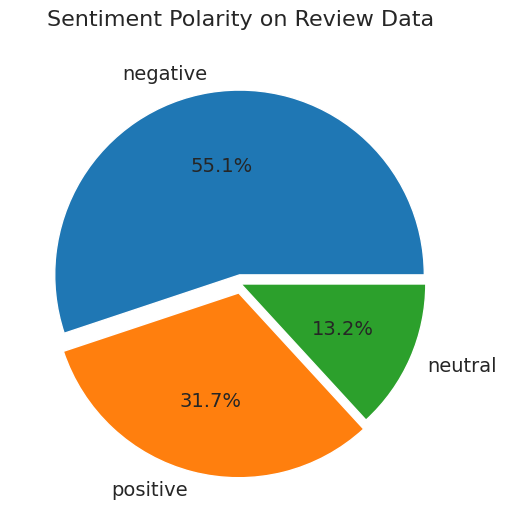

In [146]:
# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci
fig, ax = plt.subplots(figsize=(6, 6))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'clean_df' dan menyumpannya dalam list sizes
sizes = [count for count in labeled_df['polarity'].value_counts()]

# Mengambil label atau kategori sentimen dari DataFrame 'clean_df' dan menyumpannya dalam list labels
labels = list(labeled_df['polarity'].value_counts().index)

# Menentukan seberapa jauh potongan dari pie chart akan ditarik (0.05 artinya potongan pertama dan kedua akan sedikit terpisah)
explode = (0.05, 0.05, 0)

# Membuat pie chart dengan data 'sizes' dan 'labels' dan 'explodes' yang telah ditentukan
ax.pie(
    x=sizes,
    labels=labels,
    explode=explode,
    autopct='%1.1f%%',
    textprops={'fontsize': 14},
)

# Memberikan judul pada pie chart
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)

# Menampilkan pie chart
plt.show()

## **Label Exploration**

In [147]:
def generate_tweets(polarity):
    # Mengatur opsi tampilan Pandas agar kolom dapat menapilkan teks hingga 3000 karakter
    pd.set_option('display.max_colwidth', 3000)

    # Membuat DataFrame baru 'tweets_df' yang hanya berisi tweet dengan polaritas yand ditentukan melalui parameter
    tweets_df = labeled_df[labeled_df['polarity'] == polarity]

    # Memilih kolom-kolom tertentu dari DataFrame tweets_df
    tweets_df = tweets_df[['text_final', 'polarity', 'polarity_score', 'text_stopwords']]

    # Mengurutkan DataFrame teweets_df berdasarkan 'polarity_score' secara descending
    tweets_df = tweets_df.sort_values(by='polarity_score', ascending=False)

    # Mengatur ulamg indeks DataFrame agar dimulai dari 0
    tweets_df = tweets_df.reset_index(drop=True)

    # Menambahkan 1 ke semua indeks DataFrame
    tweets_df.index += 1
    return tweets_df

In [148]:
def show_wordcloud_from_tweets(tweets, title):
    # Membuat string kosong untuk mengumpulkan kata dari teks yang sudah dibersihkan
    list_words = ""

    # Iterasi setiap tweet
    for tweet in tweets:
        # Iterasi setiap kata dalam tweet
        for word in tweet:
            # Menambahkan kata ke dalam list_words
            list_words += word + " "

    # Membuat objek WordCloud dengan parameter tertentu
    workcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

    # Membuat gambar dan sumbu untuk menmpikan word cloud
    fig, ax = plt.subplots(figsize=(8, 6))

    # Menetapkan judul untuk word cloud
    ax.set_title(title, fontsize=18)

    # Mematikan grid pada sumbu
    ax.grid(False)

    # Menampilkan word cloud dalam gambar
    ax.imshow(workcloud)

    # Mengatur layout gambar
    fig.tight_layout(pad=0)

    # Menyembunyikan sumbu pada word cloud
    ax.axis("off")

    # Menampikan word cloud
    plt.show()

In [149]:
# Menyiapkan positive tweets
positive_tweets = generate_tweets('positive')

# Menyiapkan negative tweets
negative_tweets = generate_tweets('negative')

# Menyiapakan netral tweets
neutral_tweets = generate_tweets('neutral')

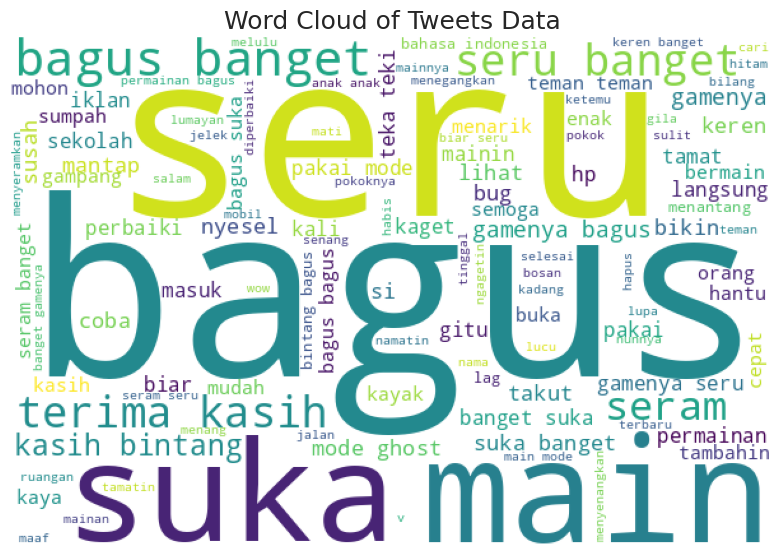

In [150]:
# Menampikan semua kata
show_wordcloud_from_tweets(labeled_df["text_stopwords"], title="Word Cloud of Tweets Data")

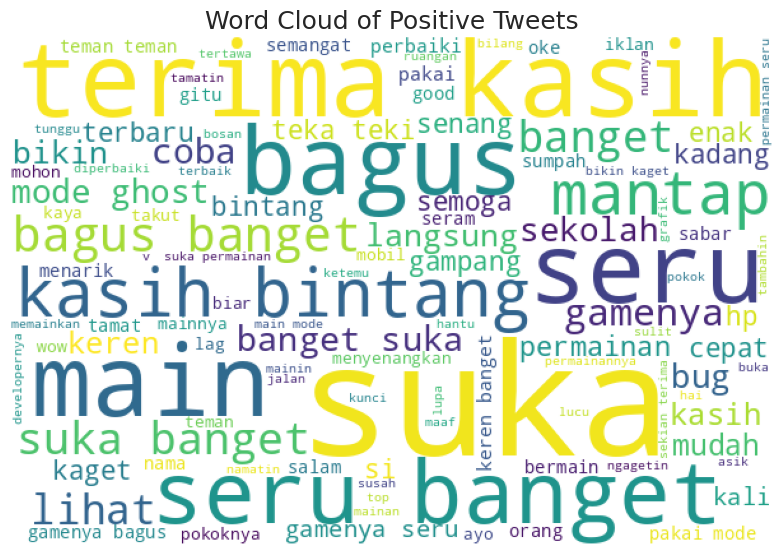

In [151]:
# Menampikan word cloud positif
show_wordcloud_from_tweets(positive_tweets['text_stopwords'], title="Word Cloud of Positive Tweets")

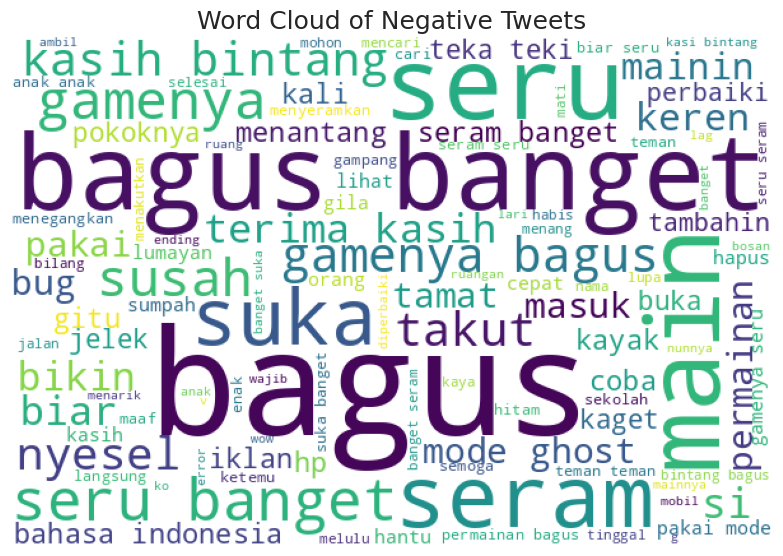

In [152]:
# Menampilkan word cloud negatif
show_wordcloud_from_tweets(negative_tweets['text_stopwords'], title="Word Cloud of Negative Tweets")

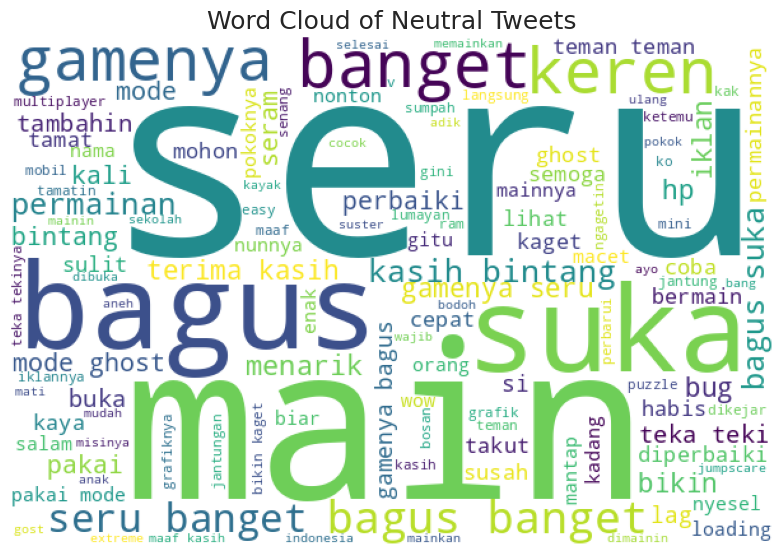

In [153]:
# Menampilkan word cloud netral
show_wordcloud_from_tweets(neutral_tweets['text_stopwords'], title="Word Cloud of Neutral Tweets")

## **Feature Extraction, Splitting Data, and Modeling**

In [270]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = labeled_df['text_final']
y = labeled_df['polarity']

# Melakukan encoding pada label
encoder = LabelEncoder()
y = encoder.fit_transform(y)

### **Experiment 1 (SVM, TF-IDF, 80/20)**

#### **Feature Extraction**

In [271]:
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=1000, min_df=15, max_df=0.8, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(X)

# Konversi hasil ekstra
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

,adik,aga,alias,alur,ambil,amin,ampe,ampun,anak,anak anak,...,untung,updatenya,utama,video,wajib,warna,wifi,wow,wow bagus,wow seru
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### **SMOTE Oversampling**

In [272]:
# Melihat disrtribusi kelas
print("Distribusi kelas sebelum SMOTE: ", Counter(y))

Distribusi kelas sebelum SMOTE:  Counter({0: 6617, 2: 3801, 1: 1582})


In [287]:
def smote_oversampling(X_data, y_data, features):
    # Inisialisasi SMOTE
    smote = SMOTE(random_state=42, sampling_strategy={
        2: 5000, 1: 3000
    })

    # Melakukan oversampling pada dataset
    X_resampled, y_resampled = smote.fit_resample(X_data, y_data)

    # Menampilkan distribusi kelas setelah SMOTE
    print("Distribusi kelas setelah SMOTE: ", Counter(y_resampled))

    # Mengubah hasil menjadi DataFrame
    X_resampled = pd.DataFrame(X_resampled.toarray(), columns=features.get_feature_names_out())
    y_resampled = pd.Series(y_resampled, name='Polarity')

    return X_resampled, y_resampled

X_resampled, y_resampled = smote_oversampling(X_tfidf, y, tfidf)

Distribusi kelas setelah SMOTE:  Counter({0: 6617, 2: 5000, 1: 3000})


#### **Spliting Data**

In [288]:
# Membagi data menjadi data latih dan data uji
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_resampled, y_resampled, test_size=0.2,
                                                                    random_state=42)

#### **Building Model**

In [277]:
# Membuat objek model SVM
svm = SVC(random_state=42)

# Melatih model SVM pada data pelatihan
svm.fit(X_train_svm, y_train_svm)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svm = svm.predict(X_train_svm)
y_pred_test_svm = svm.predict(X_test_svm)

# Evaluasi akurasi model SVM
accuracy_score_train_svm = accuracy_score(y_pred_train_svm, y_train_svm)
accuracy_score_test_svm = accuracy_score(y_pred_test_svm, y_test_svm)

# Menampilkan akurasi
print(f"SVM - accuracy_train: {accuracy_score_train_svm:.2f} ")
print(f"SVM - accuracy_test: {accuracy_score_test_svm:.2f}", )

SVM - accuracy_train: 0.94 
SVM - accuracy_test: 0.87


### **Experiment 2 (RF, BoW, 80/20)**

#### **Feature Extraction**

In [311]:
# Inisialisasi object CountVectorizer
count_vectorizer = CountVectorizer(max_features=1000, min_df=15, max_df=0.8, ngram_range=(1, 2))

# Ekstraksi fitur dengan CountVectorizer
bow_matrix = count_vectorizer.fit_transform(X)

# Konversi hasil ekstra
features_df = pd.DataFrame(bow_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

,adik,aga,alias,alur,ambil,amin,ampe,ampun,anak,anak anak,...,untung,updatenya,utama,video,wajib,warna,wifi,wow,wow bagus,wow seru
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### **SMOTE Oversampling**

In [321]:
X_resampled, y_resampled = smote_oversampling(bow_matrix, y, count_vectorizer)

Distribusi kelas setelah SMOTE:  Counter({0: 6617, 2: 5000, 1: 3000})


#### **Splitting Data**

In [322]:
# Membagi data menjadi data latih dan data uji
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

#### **Building Model**

In [324]:
# Mambuat objek model Random Forest
random_forest = RandomForestClassifier(random_state=42)

# Melatih model Random Forest pada data pelatihan
random_forest.fit(X_train_rf, y_train_rf)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = random_forest.predict(X_train_rf)
y_pred_test_rf = random_forest.predict(X_test_rf)

# Menghitung nilai akurasi dari model Random Forest
accuracy_score_train_rf = accuracy_score(y_pred_train_rf, y_train_rf)
accuracy_score_test_rf = accuracy_score(y_pred_test_rf, y_test_rf)

# Menampilkan nilai akurasi
print(f"Random Forest - accuracy_train: {accuracy_score_train_rf:.2f}")
print(f"Random Forest - accuracy_test: {accuracy_score_test_rf:.2f}")

Random Forest - accuracy_train: 0.97
Random Forest - accuracy_test: 0.81


### **Experiment 3 (NB, TF-IDF, 80/20)**

#### **Feature Extraction**

In [325]:
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=1000, min_df=15, max_df=0.8, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(X)

# Konversi hasil ekstraksi
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

,adik,aga,alias,alur,ambil,amin,ampe,ampun,anak,anak anak,...,untung,updatenya,utama,video,wajib,warna,wifi,wow,wow bagus,wow seru
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### **SMOTE Oversampling**

In [326]:
X_resampled, y_resampled = smote_oversampling(X_tfidf, y, tfidf)

Distribusi kelas setelah SMOTE:  Counter({0: 6617, 2: 5000, 1: 3000})


#### **Splitting Data**

In [327]:
# Membagi data menjadi data latih dan data uji
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

#### **Building Model**

In [328]:
# Membuat objeck model Naive Bayes (MyultinomialNB)
naive_bayes = MultinomialNB()

# Melatih model Naive Bayes pada data pelatihan
naive_bayes.fit(X_train_nb, y_train_nb)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_nb = naive_bayes.predict(X_train_nb)
y_pred_test_nb = naive_bayes.predict(X_test_nb)

# Evaluasi akurasi model Naive Bayes
accuracy_train_nb = accuracy_score(y_pred_train_nb, y_train_nb)
accuracy_test_nb = accuracy_score(y_pred_test_nb, y_test_nb)

# Menampilkan nilai akurasi
print(f"Naive Bayes - accuracy_train: {accuracy_train_nb:.2f}")
print(f"Naive Bayes - accuracy_test: {accuracy_test_nb:.2f}")

Naive Bayes - accuracy_train: 0.77
Naive Bayes - accuracy_test: 0.74


### **Experiment 4 (Logistic Regsression)**

#### **Feature Extraction**

In [329]:
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=1000, min_df=15, max_df=0.8, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(X)

# Konversi hasil ekstra
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

,adik,aga,alias,alur,ambil,amin,ampe,ampun,anak,anak anak,...,untung,updatenya,utama,video,wajib,warna,wifi,wow,wow bagus,wow seru
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### **SMOTE Oversampling**

In [330]:
X_resampled, y_resampled = smote_oversampling(X_tfidf, y, tfidf)

Distribusi kelas setelah SMOTE:  Counter({0: 6617, 2: 5000, 1: 3000})


#### **Splitting Data**

In [331]:
# Membagi data menjadi data latih dan data uji
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

#### **Building Model**

In [332]:
# Membuaat model Linear Regression
lr = LogisticRegression(random_state=42)

# Melatih model Linear Regression pada data pelatihan
lr.fit(X_train_lr, y_train_lr)

# prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = lr.predict(X_train_lr)
y_pred_test_lr = lr.predict(X_test_lr)

# Evaluasi akurasi model Linear Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train_lr)
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test_lr)

# Menampilkan akurasi
print(f"Logistic Regression - accuracy_train: {accuracy_train_lr:.2f}")
print(f"Logistic Regression - accuracy_test: {accuracy_test_lr:.2f}")

Logistic Regression - accuracy_train: 0.88
Logistic Regression - accuracy_test: 0.85


## **Model Evaluation**

In [333]:
# Menghitung MSE untuk data latih dan data uji pada percobaan 1
train_mse_svm = mean_squared_error(y_train_svm, y_pred_train_svm)
test_mse_svm = mean_squared_error(y_test_svm, y_pred_test_svm)

# Menghitung MSE untuk data latih dan data uji pada percobaan 2
train_mse_rf = mean_squared_error(y_train_rf, y_pred_train_rf)
test_mse_rf = mean_squared_error(y_test_rf, y_pred_test_rf)

# Menghitung MSE untuk data latih dan data uji percobaan 3
train_mse_nb = mean_squared_error(y_train_nb, y_pred_train_nb)
test_mse_nb = mean_squared_error(y_test_nb, y_pred_test_nb)

# menghitung MSE untuk data latih dan data uji percobaan 4
train_mse_lr = mean_squared_error(y_train_lr, y_pred_train_lr)
test_mse_lr = mean_squared_error(y_test_lr, y_pred_test_lr)

# Menampilkan hasil MSE
print(f"Training MSE for SVM: {train_mse_svm:.2f}")
print(f"Test MSE for SVM: {test_mse_svm:.2f}")
print(f"Training MSE for RF: {train_mse_rf:.2f}")
print(f"Test MSE for RF: {test_mse_rf:.2f}")
print(f"Training MSE for NB: {train_mse_nb:.2f}")
print(f"Test MSE for NB: {test_mse_nb:.2f}")
print(f"Training MSE for LR: {train_mse_lr:.2f}")
print(f"Test MSE for LR: {test_mse_lr:.2f}")

Training MSE for SVM: 0.17
Test MSE for SVM: 0.25
Training MSE for RF: 0.06
Test MSE for RF: 0.46
Training MSE for NB: 0.47
Test MSE for NB: 0.54
Training MSE for LR: 0.24
Test MSE for LR: 0.29


In [202]:
# Menggunakan cross-validation dengan 5 fold pada model SVM
cross_val_scores_svm = cross_val_score(svm, X_train_svm.toarray(), y_train_svm, cv=5, scoring='neg_mean_squared_error')

# Menggunakan cross-validation dengan 5 fold pada model Random Forest
cross_val_scores_rf = cross_val_score(random_forest, X_train_rf.toarray(), y_train_rf, cv=5,
                                      scoring='neg_mean_squared_error')

# Menggunakan cross-validation dengan 5 fold pada model Naive Bayes
cross_val_scores_nb = cross_val_score(naive_bayes, X_train_nb.toarray(), y_train_nb, cv=5,
                                      scoring='neg_mean_squared_error')

# Menggunakan cross-validation dengan 5 fold pada model Linear Regression
cross_val_scores_lr = cross_val_score(lr, X_train_lr.toarray(), y_train_lr, cv=5, scoring='neg_mean_squared_error')

# Menampilkan hasil cross-validation
print(f"Cross-Validation MSE for SVM: {-cross_val_scores_svm.mean()}")
print(f"Cross-Validation MSE for RF: {-cross_val_scores_rf.mean()}")
print(f"Cross-Validation MSE for NB: {-cross_val_scores_nb.mean()}")
print(f"Cross-Validation MSE for LR: {-cross_val_scores_lr.mean()}")

Cross-Validation MSE for SVM: 0.39260416666666664
Cross-Validation MSE for RF: 0.4966666666666667
Cross-Validation MSE for NB: 0.6247916666666666
Cross-Validation MSE for LR: 0.35739583333333336


## **Hyperparameter Tunning**

In [335]:
# Definisilan paramter grid untuk Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(random_forest, param_grid, cv=3, n_jobs=1, verbose=2)
grid_search.fit(X_train_rf, y_train_rf)

# Output hasil terbaik
print(f"Best parameters (Grid Search): {grid_search.best_params_}")
best_rf_gird = grid_search.best_estimator_

# Evaluasi performa model pada test set
grid_search_score = best_rf_gird.score(X_test_rf, y_test_rf)
print(f"Accuracy RF after Grid Search {grid_search_score:.2f}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=200; total time=   2.4s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=300; total time=   4.3s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=300; total time=   5.1s
[CV] END criterion=gini, max_depth=10, min_samples_split=2, n_estimators=300; total time=   4.4s
[CV] END criterion=gini, max_depth=10, min_samples_split=5, n_est

In [281]:
# Definisikan paramater grid untuk Grid Search
param_grid_svm = {
    'kernel': ['linear'],
    'C': [0.01, 0.1, 1, 10]
}

# Inisialisasi GridSearchCV
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=3, n_jobs=1, verbose=2)
grid_search_svm.fit(X_train_svm, y_train_svm)

# Output hasil terbaik
print(f"Best parameters (Grid Search): {grid_search_svm.best_params_}")
best_svm_grid = grid_search_svm.best_estimator_

# Evalusasi performa model pada test set
grid_search_score_svm = best_svm_grid.score(X_test_svm, y_test_svm)
print(f"Accuracy SVM after Grid Search: {grid_search_score_svm:.2f}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ..............................C=0.01, kernel=linear; total time=  45.5s
[CV] END ..............................C=0.01, kernel=linear; total time=  37.8s
[CV] END ..............................C=0.01, kernel=linear; total time=  35.8s
[CV] END ...............................C=0.1, kernel=linear; total time=  33.2s
[CV] END ...............................C=0.1, kernel=linear; total time=  37.0s
[CV] END ...............................C=0.1, kernel=linear; total time=  37.9s
[CV] END .................................C=1, kernel=linear; total time=  27.5s
[CV] END .................................C=1, kernel=linear; total time=  26.5s
[CV] END .................................C=1, kernel=linear; total time=  26.3s
[CV] END ................................C=10, kernel=linear; total time=  22.0s
[CV] END ................................C=10, kernel=linear; total time=  21.7s
[CV] END ................................C=10, ke

In [339]:
# Definisikan parameter grid untuk Grid Search
param_grid_nb = {
    'alpha': [0.01, 0.1, 1, 10],
    'fit_prior': [True, False]
}

# Inisialisasi GridSearchCV
grid_serach_nb = GridSearchCV(naive_bayes, param_grid_nb, cv=3, n_jobs=1, verbose=2)
grid_serach_nb.fit(X_train_nb, y_train_nb)

# Output hasil terbaik
print(f"Best parameters (Grid Search): {grid_serach_nb.best_params_}")
best_nb_grid = grid_serach_nb.best_estimator_

# Evaluasi performa model pada test set
grid_search_score_nb = best_nb_grid.score(X_test_nb, y_test_nb)
print(f"Accuracy NB after Grid Search: {grid_search_score_nb:.2f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END .........................alpha=0.01, fit_prior=True; total time=   0.1s
[CV] END .........................alpha=0.01, fit_prior=True; total time=   0.1s
[CV] END .........................alpha=0.01, fit_prior=True; total time=   0.1s
[CV] END ........................alpha=0.01, fit_prior=False; total time=   0.1s
[CV] END ........................alpha=0.01, fit_prior=False; total time=   0.1s
[CV] END ........................alpha=0.01, fit_prior=False; total time=   0.1s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.1s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.1s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.1s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.1s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.1s
[CV] END .........................alpha=0.1, fit_

In [342]:
# Definisikan parameter grid untuk Grid Search
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Inisialisasi GridSearchCV
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=3, n_jobs=1, verbose=2)
grid_search_lr.fit(X_train_lr, y_train_lr)

# Output hasil terbaik
print(f"Best parameters (Grid Search): {grid_search_lr.best_params_}")
best_lr_grid = grid_search_lr.best_estimator_

# Evaluasi performa model pada test set
grid_search_score_lr = best_lr_grid.score(X_test_lr, y_test_lr)
print(f"Accuracy LR after Grid Search: {grid_search_score_lr:.2f}")

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.5s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   2.9s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   2.6s
[CV] END .....................C=0.01, penalty=l

/home/refanzzzz/miniconda3/envs/sentiment-analysis-game-evil-nun2-origins/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=1, penalty=l1, solver=saga; total time=  14.5s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=  10.8s
[CV] END ..........C=1, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END ..........C=1, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END ..........C=1, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END ..............C=1, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END ..............C=1, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END ..............C=1, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END ..........C=1, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END ..........C=1, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END ..........C=1, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END ................C=1, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END ................C=1

/home/refanzzzz/miniconda3/envs/sentiment-analysis-game-evil-nun2-origins/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   2.7s


/home/refanzzzz/miniconda3/envs/sentiment-analysis-game-evil-nun2-origins/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   2.5s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.2s


/home/refanzzzz/miniconda3/envs/sentiment-analysis-game-evil-nun2-origins/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=10, penalty=l2, solver=sag; total time=  10.2s


/home/refanzzzz/miniconda3/envs/sentiment-analysis-game-evil-nun2-origins/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=10, penalty=l2, solver=sag; total time=   9.7s


/home/refanzzzz/miniconda3/envs/sentiment-analysis-game-evil-nun2-origins/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=10, penalty=l2, solver=sag; total time=   8.9s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   7.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   7.4s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   6.3s
[CV] END .................C=10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END .................C=

/home/refanzzzz/miniconda3/envs/sentiment-analysis-game-evil-nun2-origins/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time=  15.9s


/home/refanzzzz/miniconda3/envs/sentiment-analysis-game-evil-nun2-origins/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time=  16.2s


/home/refanzzzz/miniconda3/envs/sentiment-analysis-game-evil-nun2-origins/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time=  14.9s
[CV] END .........C=10, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END .........C=10, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END .........C=10, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END .............C=10, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END .............C=10, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END .............C=10, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END .........C=10, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END .........C=10, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END .........C=10, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END ...............C=10, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END ...............C=10

/home/refanzzzz/miniconda3/envs/sentiment-analysis-game-evil-nun2-origins/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
96 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/home/refanzzzz/miniconda3/envs/sentiment-analysis-game-evil-nun2-origins/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/refanzzzz/miniconda3/envs/sentiment-analysis-game-evil-nun2-origins/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args

Best parameters (Grid Search): {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Accuracy LR after Grid Search: 0.86


## **Evalution Model after Tuning**

In [336]:
# Inisialisasi model RF setelah dilakukan hyperparameter tuning
rf_tuning = RandomForestClassifier(n_estimators=200, max_depth=30, min_samples_split=2, criterion='gini')

# Melatih model Rf pada data pelatihan
rf_tuning.fit(X_train_rf, y_train_rf)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = rf_tuning.predict(X_train_rf)
y_pred_test_rf = rf_tuning.predict(X_test_rf)

# Menghitung nilai akurasi dari model Random Forest
accuracy_score_train_rf = accuracy_score(y_pred_train_rf, y_train_rf)
accuracy_score_test_rf = accuracy_score(y_pred_test_rf, y_test_rf)

# Menampilkan nilai akurasi
print(f"Random Forest Tuning - accuracy_train: {accuracy_score_train_rf:.2f}")
print(f"Random Forest Tuning - accuracy_test: {accuracy_score_test_rf:.2f}")

Random Forest Tuning - accuracy_train: 0.86
Random Forest Tuning - accuracy_test: 0.80


In [337]:
# Inisalisasi model SVM setelah dilakukan hyperparameter tuning
svm_tuning = SVC(kernel='linear', C=10, random_state=42)

# Melatih model SVM pada data pelatihan
svm_tuning.fit(X_train_svm, y_train_svm)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svm = svm_tuning.predict(X_train_svm)
y_pred_test_svm = svm_tuning.predict(X_test_svm)

# Evaluasi akurasi model SVM
accuracy_score_train_svm = accuracy_score(y_pred_train_svm, y_train_svm)
accuracy_score_test_svm = accuracy_score(y_pred_test_svm, y_test_svm)

# Menampilkan akurasi
print(f"SVM Tuning - accuracy_train: {accuracy_score_train_svm:.2f} ")
print(f"SVM Tuning - accuracy_test: {accuracy_score_test_svm:.2f}", )

SVM Tuning - accuracy_train: 0.91 
SVM Tuning - accuracy_test: 0.86


In [340]:
# Inisialisasi model Naive Bayse setelah dilakukan hyperparameter tuning
nb_tuning = MultinomialNB(alpha=10, fit_prior=False)

# Melatih model Naive Bayes pada data pelatihan
nb_tuning.fit(X_train_nb, y_train_nb)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_nb = nb_tuning.predict(X_train_nb)
y_pred_test_nb = nb_tuning.predict(X_test_nb)

# Evaluasi akurasi model Naive Bayes
accuracy_train_nb = accuracy_score(y_pred_train_nb, y_train_nb)
accuracy_test_nb = accuracy_score(y_pred_test_nb, y_test_nb)

# Menampilkan nilai akurasi
print(f"Naive Bayes Tuning - accuracy_train: {accuracy_train_nb:.2f}")
print(f"Naive Bayes Tuning - accuracy_test: {accuracy_test_nb:.2f}")

Naive Bayes Tuning - accuracy_train: 0.76
Naive Bayes Tuning - accuracy_test: 0.72


In [343]:
# Inisialisasi model Logistic Regression setelah dilakukan hyperparameter tuning
lr_tuning = LogisticRegression(C=1, penalty='l1', solver='saga', random_state=42)

# Melatih model Logistic Regression pada data pelatihan
lr_tuning.fit(X_train_lr, y_train_lr)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = lr_tuning.predict(X_train_lr)
y_pred_test_lr = lr_tuning.predict(X_test_lr)

# Evaluasi akurasi model Logistic Regression
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train_lr)
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test_lr)

# Menampilkan nilai akurasi
print(f"Logistic Regression Tuning - accuracy_train: {accuracy_train_lr:.2f}")
print(f"Logistic Regression Tuning - accuracy_test: {accuracy_test_lr:.2f}")

Logistic Regression Tuning - accuracy_train: 0.89
Logistic Regression Tuning - accuracy_test: 0.86


## **Analysis Evaluation Result of Model**

In [ ]:
# Menghitung MSE untuk data latih dan data uji pada percobaan 1
train_mse_rf_tuning = mean_squared_error(y_train_rf, y_pred_train_rf)
test_mse_rf_tuning = mean_squared_error(y_test_rf, y_pred_test_rf)